In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time

from sklearn.feature_selection import SelectKBest, f_classif
from bayes_opt import BayesianOptimization
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, auc
from sklearn.metrics import confusion_matrix
from mlxtend.evaluate import bias_variance_decomp

from itertools import combinations
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

import warnings
warnings.filterwarnings("ignore")

## Reading the Preprocessed Data

In [2]:
data1 = pd.read_csv('New_Data/data_1.csv')
data2 = pd.read_csv('New_Data/data_2.csv')
data3 = pd.read_csv('New_Data/data_3.csv')
data4 = pd.read_csv('New_Data/data_4.csv')
data5 = pd.read_csv('New_Data/data_5.csv')

datasets = [data1, data2, data3, data4, data5]

# Drop 'start_index' and 'end_index' columns
for data in datasets:
    data.drop(['start_index', 'end_index'], axis=1, inplace=True)

In [3]:
datasets[1].head()

,mean_acc,rms_acc,std_acc,iqr_acc,max_min_acc,mean_freq_power_acc,label
0,-0.078727,0.821799,0.818020,0.971270,3.14364,3.547181,1.0
1,-0.072592,0.819337,0.816115,0.971270,3.14364,3.496016,1.0
2,-0.065807,0.816776,0.814121,0.971270,3.14364,3.468864,1.0
3,-0.053758,0.813843,0.812065,0.962035,3.14364,3.445769,1.0
4,-0.041650,0.816196,0.815133,1.044691,3.14364,3.480780,1.0


## Get the features and labels and encode them

In [4]:
df = pd.concat(datasets, ignore_index=True)
X = df.drop('label', axis=1)
y = df['label']

In [5]:
X.head()

,mean_acc,rms_acc,std_acc,iqr_acc,max_min_acc,mean_freq_power_acc
0,-0.002653,0.192510,0.192492,0.383497,0.660868,0.751877
1,-0.002048,0.191829,0.191818,0.383497,0.660868,0.745700
2,-0.001978,0.191754,0.191744,0.383497,0.660868,0.744612
3,-0.004017,0.192088,0.192046,0.383497,0.660868,0.744781
4,-0.006056,0.192421,0.192326,0.383497,0.660868,0.757820


In [6]:
y.head()  

0    1.0
1    1.0
2    1.0
3    1.0
4    1.0
Name: label, dtype: float64

# Classification with Naive Bayes
## Hyperparameters finetuning
### create the objective function

In [15]:
def cross_validation_nb(datasets, k1):
    """
    Effectue une validation croisée pour naive bayes en utilisant 4 fichiers pour le train
    et 1 pour le test, avec sélection de caractéristiques.

    :param datasets: Liste de DataFrames.
    :param k1: Nombre de caractéristiques à sélectionner.
    :return: Liste des résultats pour chaque combinaison.
    """
    results = []

    # Combinaisons des fichiers (4 pour le train, 1 pour le test)
    for combination in combinations(range(len(datasets)), 4):
        # Indices des fichiers de train et de test
        train_indices = [i + 1 for i in combination]
        test_index = [i + 1 for i in range(len(datasets)) if i not in combination][0]

        # Créer l'ensemble d'entraînement et de test
        train_data = pd.concat([datasets[i] for i in combination])
        test_data = datasets[[i for i in range(len(datasets)) if i not in combination][0]]

        # Séparer les features (X) et les labels (y)
        X_train, y_train = train_data.drop(columns=['label']), train_data['label']
        X_test, y_test = test_data.drop(columns=['label']), test_data['label']

        # Sélection des caractéristiques
        selector = SelectKBest(score_func=f_classif, k=int(k1))
        X_train_selected = selector.fit_transform(X_train, y_train)
        X_test_selected = selector.transform(X_test)

        # Entraîner le modèle gaussien naïf bayésien
        clf = GaussianNB()
        clf.fit(X_train_selected, y_train)

        # Prédire sur les données de test
        y_pred = clf.predict(X_test_selected)

        # Calculer le F1-score
        score = f1_score(y_test, y_pred, average='weighted')
        results.append((train_indices, test_index, score))

    return results

# Paramètre pour le nombre de caractéristiques
k1 = 6

# Lancer la validation croisée
results = cross_validation_nb(datasets, k1)

# Afficher les résultats
for i, (train_files, test_file, score) in enumerate(results, 1):
    print(f"### Combinaison {i} ###")
    print(f"Fichiers pour le train: {train_files}")
    print(f"Fichier pour le test: {test_file}")
    print(f"F1-score pour cette combinaison: {score:.4f}\n")

# Moyenne des F1-scores
mean_score = np.mean([score for _, _, score in results])
print(f"Moyenne des F1-scores : {mean_score:.4f}")

# Ecart-type des F1-scores
std_score = np.std([score for _, _, score in results])
print(f"Ecart-type des F1-scores : {std_score:.4f}")

### Combinaison 1 ###
Fichiers pour le train: [1, 2, 3, 4]
Fichier pour le test: 5
F1-score pour cette combinaison: 0.9581

### Combinaison 2 ###
Fichiers pour le train: [1, 2, 3, 5]
Fichier pour le test: 4
F1-score pour cette combinaison: 0.7246

### Combinaison 3 ###
Fichiers pour le train: [1, 2, 4, 5]
Fichier pour le test: 3
F1-score pour cette combinaison: 0.9615

### Combinaison 4 ###
Fichiers pour le train: [1, 3, 4, 5]
Fichier pour le test: 2
F1-score pour cette combinaison: 0.9049

### Combinaison 5 ###
Fichiers pour le train: [2, 3, 4, 5]
Fichier pour le test: 1
F1-score pour cette combinaison: 0.3646

Moyenne des F1-scores : 0.7827
Ecart-type des F1-scores : 0.2262


In [16]:
def my_naivebayes(k1): 
    # Perform feature selection
    selector = SelectKBest(score_func=f_classif, k=int(k1))
    X_selected = selector.fit_transform(X, y)
    X_selected = pd.DataFrame(X_selected, columns=X.columns[selector.get_support()])

    # split data into train and test sets
    X_train = pd.concat([data1, data2, data4, data5]).drop('label', axis=1)
    y_train = pd.concat([data1, data2, data4, data5])['label']
    X_test = data3.drop('label', axis=1)
    y_test = data3['label']

    # Select the features for the test data
    X_test = X_test[X_selected.columns].to_numpy()
    X_train = X_train[X_selected.columns].to_numpy()

    # Create a Naive Bayes classifier
    clf = GaussianNB()

    # Train the classifier
    clf.fit(X_train, y_train)

    # Make predictions on the test data
    y_pred = clf.predict(X_test)

    # Evaluate the model
    return f1_score(y_test, y_pred, average='weighted')

### Finetuning using Bayesian Optimization

In [17]:
pbounds = {
    'k1': (1, 6)
    }

optimizer = BayesianOptimization(
    f=my_naivebayes,
    pbounds=pbounds,
    verbose=2,
    random_state=1,
)

start = time.time()
optimizer.maximize(init_points=10, n_iter=10)
end = time.time()
print('Bayes optimization takes {:.2f} seconds to tune'.format(end - start))
print(optimizer.max)

|   iter    |  target   |    k1     |
-------------------------------------
| 1         | 0.9588    | 3.085     |
| 2         | 0.959     | 4.602     |
| 3         | 0.9533    | 1.001     |
| 4         | 0.9581    | 2.512     |
| 5         | 0.9533    | 1.734     |
| 6         | 0.9533    | 1.462     |
| 7         | 0.9533    | 1.931     |
| 8         | 0.9581    | 2.728     |
| 9         | 0.9581    | 2.984     |
| 10        | 0.9588    | 3.694     |
| 11        | 0.9601    | 5.31      |
| 12        | 0.9601    | 5.989     |
| 13        | 0.9601    | 5.328     |
| 14        | 0.9601    | 5.723     |
| 15        | 0.959     | 4.176     |
| 16        | 0.9601    | 5.312     |
| 17        | 0.959     | 4.96      |
| 18        | 0.9588    | 3.385     |
| 19        | 0.9601    | 5.864     |
| 20        | 0.9601    | 5.546     |
Bayes optimization takes 2.39 seconds to tune
{'target': np.float64(0.9600859966618857), 'params': {'k1': np.float64(5.309558952764376)}}


In [18]:
# Perform feature selection
selector = SelectKBest(score_func=f_classif, k=6)
X_selected = selector.fit_transform(X, y)
X_selected = pd.DataFrame(X_selected, columns=X.columns[selector.get_support()])

# split data into train and test sets
X_train = pd.concat([data1, data2, data4, data5]).drop('label', axis=1)
y_train = pd.concat([data1, data2, data4, data5])['label']
X_test = data3.drop('label', axis=1)
y_test = data3['label']

# Select the features for the test data
X_test = X_test[X_selected.columns].to_numpy()
X_train = X_train[X_selected.columns].to_numpy()

# Create a Naive Bayes classifier
clf = GaussianNB()

start_time = time.time()

# Train the classifier
clf.fit(X_train, y_train)

# Make predictions on the test data
y_pred = clf.predict(X_test)

execution_time = time.time() - start_time

# Evaluate the performance of the classifier
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted') 
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

# ROC curve multi-class classification
y_prob = clf.predict_proba(X_test).argmax(axis=1)
macro_roc_auc_ovo = roc_auc_score(y_test.to_numpy(), y_prob, multi_class="ovo", average="macro")

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Get the TP, TN, FP, FN values
FP = cm.sum(axis=0) - np.diag(cm)  
FN = cm.sum(axis=1) - np.diag(cm)
TP = np.diag(cm)
TN = cm.sum() - (FP + FN + TP)

# Get the bias and variance of the classifier
loss, bias, var = bias_variance_decomp(clf,X_train, y_train.to_numpy(), X_test, y_test.to_numpy(), loss='0-1_loss',random_seed=23)

# Print the evaluation metrics
print("Loss:", loss)
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)
print("TP:", TP.sum())
print("TN:", TN.sum())
print("FP:", FP.sum())
print("FN:", FN.sum())
print("AUC:", macro_roc_auc_ovo)
print("Bias:", bias)
print("Variance:", var)
print(f"Execution Time: {execution_time} seconds")

Loss: 0.03869821231890197
Accuracy: 0.9612979750910785
Precision: 0.9628196049703747
Recall: 0.9612979750910785
F1 Score: 0.9614571484189166
TP: 56731
TN: 56731
FP: 2284
FN: 2284
AUC: 0.9646938771411482
Bias: 0.038718969753452515
Variance: 0.00035236804202321443
Execution Time: 0.04180335998535156 seconds


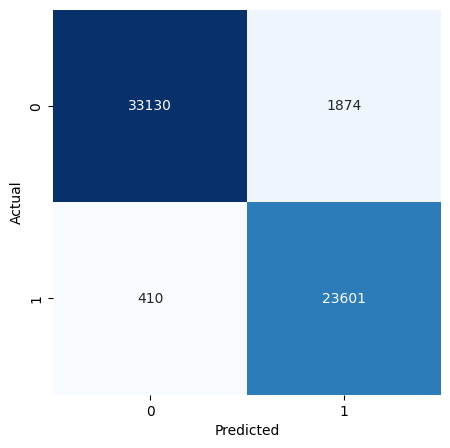

In [19]:
plt.figure(figsize=(5, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

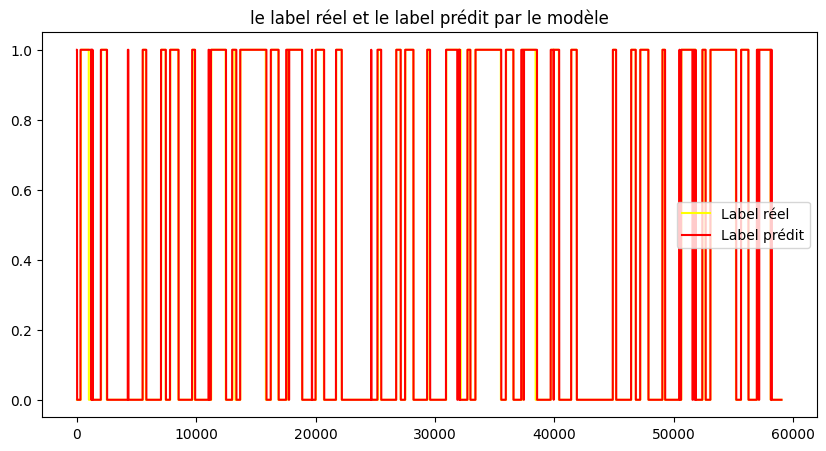

In [20]:
plt.figure(figsize=(10, 5))
plt.plot(y_test, label='Label réel',color='yellow')
plt.plot(y_pred, label='Label prédit',color='red')
plt.title('le label réel et le label prédit par le modèle')
plt.legend()
plt.show()

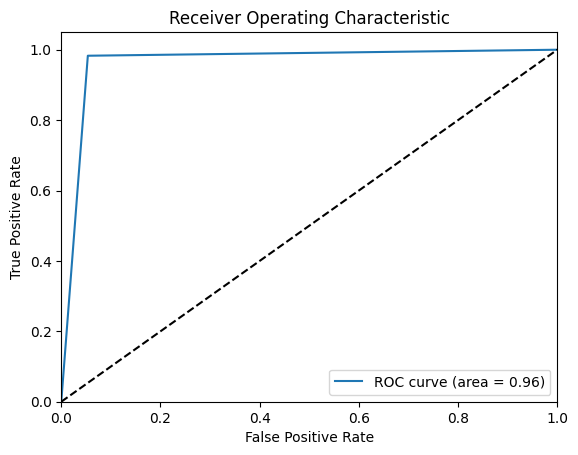

In [21]:
# Compute the false positive rate, true positive rate, and thresholds
fpr, tpr, thresholds = roc_curve(y_test, y_prob)

# Compute the area under the ROC curve
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.plot(fpr, tpr, label='ROC curve (area = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

# Classification with Decision trees
## Hyperparameters finetuning
### create the objective function

In [ ]:
def cross_validation_dt(datasets, k1, md, msl, mss):
    """
    Effectue une validation croisée pour decision tree en utilisant 4 fichiers pour le train
    et 1 pour le test, avec sélection de caractéristiques.

    :param datasets: Liste de DataFrames.
    :param k1: Nombre de caractéristiques à sélectionner.
    :param md: Profondeur maximale de l'arbre.
    :param msl: Nombre minimal d'échantillons dans une feuille.
    :param mss: Nombre minimal d'échantillons pour scinder un noeud.
    :return: Liste des résultats pour chaque combinaison.
    """
    results = []

    # Combinaisons des fichiers (4 pour le train, 1 pour le test)
    for combination in combinations(range(len(datasets)), 4):
        # Indices des fichiers de train et de test
        train_indices = [i + 1 for i in combination]
        test_index = [i + 1 for i in range(len(datasets)) if i not in combination][0]

        # Créer l'ensemble d'entraînement et de test
        train_data = pd.concat([datasets[i] for i in combination])
        test_data = datasets[[i for i in range(len(datasets)) if i not in combination][0]]

        # Séparer les features (X) et les labels (y)
        X_train, y_train = train_data.drop(columns=['label']), train_data['label']
        X_test, y_test = test_data.drop(columns=['label']), test_data['label']

        # Sélection des caractéristiques
        selector = SelectKBest(score_func=f_classif, k=int(k1))
        X_train_selected = selector.fit_transform(X_train, y_train)
        X_test_selected = selector.transform(X_test)

        # Entraîner le modèle decision tree
        clf = DecisionTreeClassifier(max_depth=int(md), min_samples_leaf=int(msl), min_samples_split=int(mss))
        clf.fit(X_train_selected, y_train)

        # Prédire sur les données de test
        y_pred = clf.predict(X_test_selected)

        # Calculer le F1-score
        score = f1_score(y_test, y_pred, average='weighted')
        results.append((train_indices, test_index, score))

    return results

# Paramètre pour le nombre de caractéristiques
k1 = 21
md = 9.714
msl = 3.821
mss = 7.539 

# Lancer la validation croisée
results = cross_validation_dt(datasets, k1, md, msl, mss)

# Afficher les résultats
for i, (train_files, test_file, score) in enumerate(results, 1):
    print(f"### Combinaison {i} ###")
    print(f"Fichiers pour le train: {train_files}")
    print(f"Fichier pour le test: {test_file}")
    print(f"F1-score pour cette combinaison: {score:.4f}\n")

# Moyenne des F1-scores
mean_score = np.mean([score for _, _, score in results])
print(f"Moyenne des F1-scores : {mean_score:.4f}")

# Ecart-type des F1-scores
std_score = np.std([score for _, _, score in results])
print(f"Ecart-type des F1-scores : {std_score:.4f}")

### Combinaison 1 ###
Fichiers pour le train: [1, 2, 3, 4]
Fichier pour le test: 5
F1-score pour cette combinaison: 0.9394

### Combinaison 2 ###
Fichiers pour le train: [1, 2, 3, 5]
Fichier pour le test: 4
F1-score pour cette combinaison: 0.8626

### Combinaison 3 ###
Fichiers pour le train: [1, 2, 4, 5]
Fichier pour le test: 3
F1-score pour cette combinaison: 0.9650

### Combinaison 4 ###
Fichiers pour le train: [1, 3, 4, 5]
Fichier pour le test: 2
F1-score pour cette combinaison: 0.8586

### Combinaison 5 ###
Fichiers pour le train: [2, 3, 4, 5]
Fichier pour le test: 1
F1-score pour cette combinaison: 0.3755

Moyenne des F1-scores : 0.8002
Ecart-type des F1-scores : 0.2164


In [ ]:
def my_decisiontree(k1, md, msl, mss):
    # Perform feature selection
    selector = SelectKBest(score_func=f_classif, k=int(k1))
    X_selected = selector.fit_transform(X, y)
    X_selected = pd.DataFrame(X_selected, columns=X.columns[selector.get_support()])

    # split data into train and test sets
    X_train = pd.concat([data1, data2, data4, data5]).drop('label', axis=1)
    y_train = pd.concat([data1, data2, data4, data5])['label']
    X_test = data3.drop('label', axis=1)
    y_test = data3['label']

    # Select the features for the test data
    X_test = X_test[X_selected.columns].to_numpy()
    X_train = X_train[X_selected.columns].to_numpy()

    # Create a Decision Tree classifier
    clf = DecisionTreeClassifier(max_depth=int(md), min_samples_leaf=int(msl), min_samples_split=int(mss))

    # Train the classifier
    clf.fit(X_train, y_train)

    # Make predictions on the test data
    y_pred = clf.predict(X_test)

    # Evaluate the model
    return f1_score(y_test, y_pred, average='weighted')

### Finetuning using Bayesian Optimization

In [ ]:
pbounds = {
    'k1': (5, 21), # number of features to select
    'md': (1, 10), # max_depth
    'msl': (1, 10), # min_samples_leaf
    'mss': (2, 10) # min_samples_split
    }

optimizer = BayesianOptimization(
    f=my_decisiontree,
    pbounds=pbounds,
    verbose=2,
    random_state=1,
)

start = time.time()
optimizer.maximize(init_points=10, n_iter=10)
end = time.time()
print('Bayes optimization takes {:.2f} seconds to tune'.format(end - start))
print(optimizer.max)

|   iter    |  target   |    k1     |    md     |    msl    |    mss    |
-------------------------------------------------------------------------
| 1         | 0.945     | 11.67     | 7.483     | 1.001     | 4.419     |
| 2         | 0.9426    | 7.348     | 1.831     | 2.676     | 4.764     |
| 3         | 0.94      | 11.35     | 5.849     | 4.773     | 7.482     |
| 4         | 0.9578    | 8.271     | 8.903     | 1.246     | 7.364     |
| 5         | 0.9464    | 11.68     | 6.028     | 2.263     | 3.585     |
| 6         | 0.9449    | 17.81     | 9.714     | 3.821     | 7.539     |
| 7         | 0.9519    | 19.02     | 9.051     | 1.765     | 2.312     |
| 8         | 0.9264    | 7.717     | 8.903     | 1.885     | 5.369     |
| 9         | 0.9719    | 20.33     | 5.798     | 7.227     | 4.524     |
| 10        | 0.9611    | 15.98     | 8.512     | 1.165     | 8.001     |
| 11        | 0.9426    | 5.124     | 2.457     | 7.384     | 8.118     |
| 12        | 0.9393    | 12.08     | 

### Perform Binary classification

In [ ]:
# Perform feature selection
selector = SelectKBest(score_func=f_classif, k=21)
X_selected = selector.fit_transform(X, y)
X_selected = pd.DataFrame(X_selected, columns=X.columns[selector.get_support()])

# split data into train and test sets
X_train = pd.concat([data1, data2, data4, data5]).drop('label', axis=1)
y_train = pd.concat([data1, data2, data4, data5])['label']
X_test = data3.drop('label', axis=1)
y_test = data3['label']

# Select the features for the test data
X_test = X_test[X_selected.columns].to_numpy()
X_train = X_train[X_selected.columns].to_numpy()

start_time = time.time()

# Create a Decision Tree classifier
clf = DecisionTreeClassifier(max_depth=5, min_samples_leaf=8, min_samples_split=5)

# Train the classifier
clf.fit(X_train, y_train)

# Make predictions on the test data
y_pred = clf.predict(X_test)

execution_time = time.time() - start_time

# Evaluate the performance of the classifier
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

# ROC curve multi-class classification
y_prob = clf.predict_proba(X_test).argmax(axis=1)
macro_roc_auc_ovo = roc_auc_score(y_test.to_numpy(), y_prob, multi_class="ovo", average="macro")

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Get the TP, TN, FP, FN values
FP = cm.sum(axis=0) - np.diag(cm)  
FN = cm.sum(axis=1) - np.diag(cm)
TP = np.diag(cm)
TN = cm.sum() - (FP + FN + TP)

# Get the bias and variance of the classifier
loss, bias, var = bias_variance_decomp(clf,X_train, y_train.to_numpy(), X_test, y_test.to_numpy(), loss='0-1_loss',random_seed=23)

# Print the evaluation metrics
print("Loss:", loss)
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)
print("TP:", TP.sum())
print("TN:", TN.sum())
print("FP:", FP.sum())
print("FN:", FN.sum())
print("AUC:", macro_roc_auc_ovo)
print("Bias:", bias)
print("Variance:", var)
print(f"Execution Time: {execution_time} seconds")

Loss: 0.03094094688613609
Accuracy: 0.9719158323434584
Precision: 0.9720016874174856
Recall: 0.9719158323434584
F1 Score: 0.9719399440060555
TP: 11455
TN: 11455
FP: 331
FN: 331
AUC: 0.9716794691791358
Bias: 0.026726624809095538
Variance: 0.014317834719158323
Execution Time: 1.6118199825286865 seconds


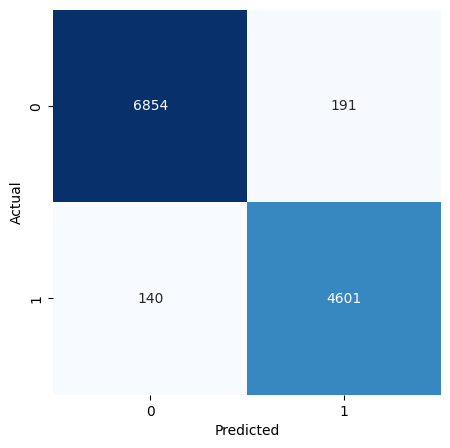

In [ ]:
plt.figure(figsize=(5, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

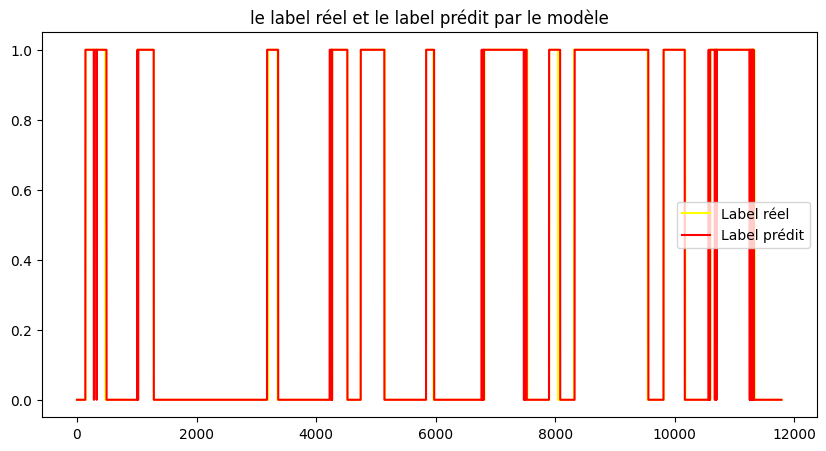

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(y_test, label='Label réel',color='yellow')
plt.plot(y_pred, label='Label prédit',color='red')
plt.title('le label réel et le label prédit par le modèle')
plt.legend()
plt.show()

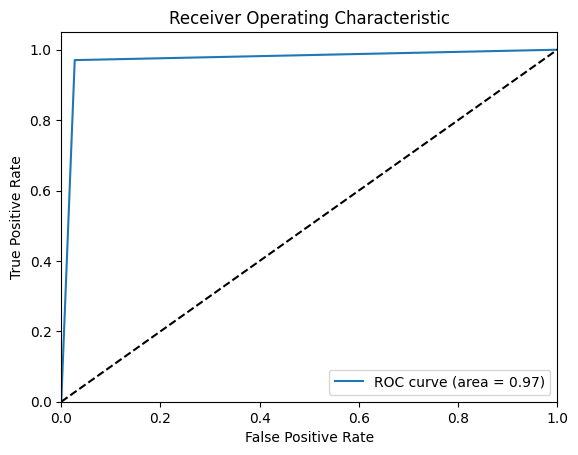

In [ ]:
# Compute the false positive rate, true positive rate, and thresholds
fpr, tpr, thresholds = roc_curve(y_test, y_prob) 

# Compute the area under the ROC curve
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.plot(fpr, tpr, label='ROC curve (area = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

# Classification with Random Forest
## Hyperparameters finetuning
### create the objective function

In [ ]:
def cross_validation_rf(datasets, k1, md, msl, mss, n):
    """
    Effectue une validation croisée pour random forest en utilisant 4 fichiers pour le train
    et 1 pour le test, avec sélection de caractéristiques.

    :param datasets: Liste de DataFrames
    :param k1: Nombre de caractéristiques à sélectionner
    :param md: Profondeur maximale de l'arbre
    :param msl: Nombre minimal d'échantillons dans une feuille
    :param mss: Nombre minimal d'échantillons pour scinder un noeud
    :param n: Nombre d'arbres dans la forêt
    :return: Liste des résultats pour chaque combinaison.
    """
    results = []

    # Combinaisons des fichiers (4 pour le train, 1 pour le test)
    for combination in combinations(range(len(datasets)), 4):
        # Indices des fichiers de train et de test
        train_indices = [i + 1 for i in combination]
        test_index = [i + 1 for i in range(len(datasets)) if i not in combination][0]

        # Créer l'ensemble d'entraînement et de test
        train_data = pd.concat([datasets[i] for i in combination])
        test_data = datasets[[i for i in range(len(datasets)) if i not in combination][0]]

        # Séparer les features (X) et les labels (y)
        X_train, y_train = train_data.drop(columns=['label']), train_data['label']
        X_test, y_test = test_data.drop(columns=['label']), test_data['label']

        # Sélection des caractéristiques
        selector = SelectKBest(score_func=f_classif, k=int(k1))
        X_train_selected = selector.fit_transform(X_train, y_train)
        X_test_selected = selector.transform(X_test)

        # Entraîner le modèle decision tree
        clf = RandomForestClassifier(max_depth=int(md), min_samples_leaf=int(msl), min_samples_split=int(mss), n_estimators=int(n))
        clf.fit(X_train_selected, y_train)

        # Prédire sur les données de test
        y_pred = clf.predict(X_test_selected)

        # Calculer le F1-score
        score = f1_score(y_test, y_pred, average='weighted')
        results.append((train_indices, test_index, score))

    return results

# Paramètre pour le nombre de caractéristiques
k1 = 21
md = 9.714
msl = 3.821
mss = 7.539 
n = 88.88

# Lancer la validation croisée
results = cross_validation_dt(datasets, k1, md, msl, mss)

# Afficher les résultats
for i, (train_files, test_file, score) in enumerate(results, 1):
    print(f"### Combinaison {i} ###")
    print(f"Fichiers pour le train: {train_files}")
    print(f"Fichier pour le test: {test_file}")
    print(f"F1-score pour cette combinaison: {score:.4f}\n")

# Moyenne des F1-scores
mean_score = np.mean([score for _, _, score in results])
print(f"Moyenne des F1-scores : {mean_score:.4f}")

# Ecart-type des F1-scores
std_score = np.std([score for _, _, score in results])
print(f"Ecart-type des F1-scores : {std_score:.4f}")

### Combinaison 1 ###
Fichiers pour le train: [1, 2, 3, 4]
Fichier pour le test: 5
F1-score pour cette combinaison: 0.9405

### Combinaison 2 ###
Fichiers pour le train: [1, 2, 3, 5]
Fichier pour le test: 4
F1-score pour cette combinaison: 0.8637

### Combinaison 3 ###
Fichiers pour le train: [1, 2, 4, 5]
Fichier pour le test: 3
F1-score pour cette combinaison: 0.9620

### Combinaison 4 ###
Fichiers pour le train: [1, 3, 4, 5]
Fichier pour le test: 2
F1-score pour cette combinaison: 0.8581

### Combinaison 5 ###
Fichiers pour le train: [2, 3, 4, 5]
Fichier pour le test: 1
F1-score pour cette combinaison: 0.3630

Moyenne des F1-scores : 0.7975
Ecart-type des F1-scores : 0.2211


In [ ]:
def my_randomforest(k1, md, msl, mss, n):
    # Perform feature selection
    selector = SelectKBest(score_func=f_classif, k=int(k1))
    X_selected = selector.fit_transform(X, y)
    X_selected = pd.DataFrame(X_selected, columns=X.columns[selector.get_support()])
    
    # split data into train and test sets
    X_train = pd.concat([data1, data2, data4, data5]).drop('label', axis=1)
    y_train = pd.concat([data1, data2, data4, data5])['label']
    X_test = data3.drop('label', axis=1)
    y_test = data3['label']

    # Select the features for the test data
    X_test = X_test[X_selected.columns].to_numpy()
    X_train = X_train[X_selected.columns].to_numpy()

    # Create a Random Forest classifier
    clf = RandomForestClassifier(max_depth=int(md), min_samples_leaf=int(msl), min_samples_split=int(mss), n_estimators=int(n))

    # Train the classifier
    clf.fit(X_train, y_train)

    # Make predictions on the test data
    y_pred = clf.predict(X_test)

    # Evaluate the model
    return f1_score(y_test, y_pred, average='weighted')

In [ ]:
pbounds = {
    'k1': (5, 21), # number of features to select
    'md': (1, 10), # max_depth
    'msl': (1, 10),# min_samples_leaf
    'mss': (2, 10), # min_samples_split
    'n': (10, 100) # n_estimators
    }

optimizer = BayesianOptimization(
    f=my_randomforest,
    pbounds=pbounds,
    verbose=2,
    random_state=1,
)

start = time.time()
optimizer.maximize(init_points=10, n_iter=10)
end = time.time()
print('Bayes optimization takes {:.2f} seconds to tune'.format(end - start))
print(optimizer.max)

|   iter    |  target   |    k1     |    md     |    msl    |    mss    |     n     |
-------------------------------------------------------------------------------------
| 1         | 0.9571    | 11.67     | 7.483     | 1.001     | 4.419     | 23.21     |
| 2         | 0.9222    | 6.477     | 2.676     | 4.11      | 5.174     | 58.49     |
| 3         | 0.9555    | 11.71     | 7.167     | 2.84      | 9.025     | 12.46     |
| 4         | 0.9611    | 15.73     | 4.756     | 6.028     | 3.123     | 27.83     |
| 5         | 0.9756    | 17.81     | 9.714     | 3.821     | 7.539     | 88.88     |
| 6         | 0.9177    | 19.31     | 1.765     | 1.351     | 3.359     | 89.03     |
| 7         | 0.9433    | 6.574     | 4.79      | 9.621     | 6.265     | 72.27     |
| 8         | 0.9582    | 10.05     | 7.179     | 8.512     | 2.146     | 77.51     |
| 9         | 0.9742    | 20.82     | 7.733     | 3.524     | 8.314     | 19.29     |
| 10        | 0.9604    | 12.17     | 9.177     | 3.64

In [ ]:
# Perform feature selection
selector = SelectKBest(score_func=f_classif, k=18)
X_selected = selector.fit_transform(X, y)
X_selected = pd.DataFrame(X_selected, columns=X.columns[selector.get_support()])

# split data into train and test sets
X_train = pd.concat([data1, data2, data4, data5]).drop('label', axis=1)
y_train = pd.concat([data1, data2, data4, data5])['label']
X_test = data3.drop('label', axis=1)
y_test = data3['label']

# Select the features for the test data
X_test = X_test[X_selected.columns].to_numpy()
X_train = X_train[X_selected.columns].to_numpy()

# Create a Random Forest classifier
clf = RandomForestClassifier(max_depth=10, min_samples_leaf= 4, min_samples_split=8, n_estimators=88)

start_time = time.time()

# Train the classifier
clf.fit(X_train, y_train)

# Make predictions on the test data
y_pred = clf.predict(X_test)

execution_time = time.time() - start_time

# Evaluate the performance of the classifier
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

# ROC curve multi-class classification
y_prob = clf.predict_proba(X_test).argmax(axis=1)
macro_roc_auc_ovo = roc_auc_score(y_test.to_numpy(), y_prob, multi_class="ovo", average="macro")

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Get the TP, TN, FP, FN values
FP = cm.sum(axis=0) - np.diag(cm)  
FN = cm.sum(axis=1) - np.diag(cm)
TP = np.diag(cm)
TN = cm.sum() - (FP + FN + TP)

# Get the bias and variance of the classifier
loss, bias, var = bias_variance_decomp(clf,X_train, y_train.to_numpy(), X_test, y_test.to_numpy(), loss='0-1_loss',random_seed=23)

# Print the evaluation metrics
print("Loss:", loss)
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)
print("TP:", TP.sum())
print("TN:", TN.sum())
print("FP:", FP.sum())
print("FN:", FN.sum())
print("AUC:", macro_roc_auc_ovo)
print("Bias:", bias)
print("Variance:", var)
print(f"Execution Time: {execution_time} seconds")

Loss: 0.025101815713558455
Accuracy: 0.9748854573222467
Precision: 0.9754376165715646
Recall: 0.9748854573222467
F1 Score: 0.9749532701824292
TP: 11490
TN: 11490
FP: 296
FN: 296
AUC: 0.9768192813577226
Bias: 0.024690310537926353
Variance: 0.004267775326658748
Execution Time: 13.687541961669922 seconds


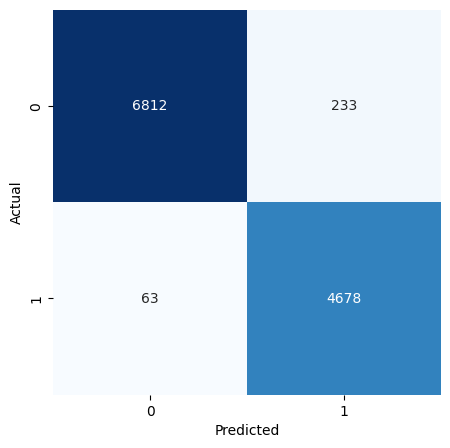

In [ ]:
plt.figure(figsize=(5, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

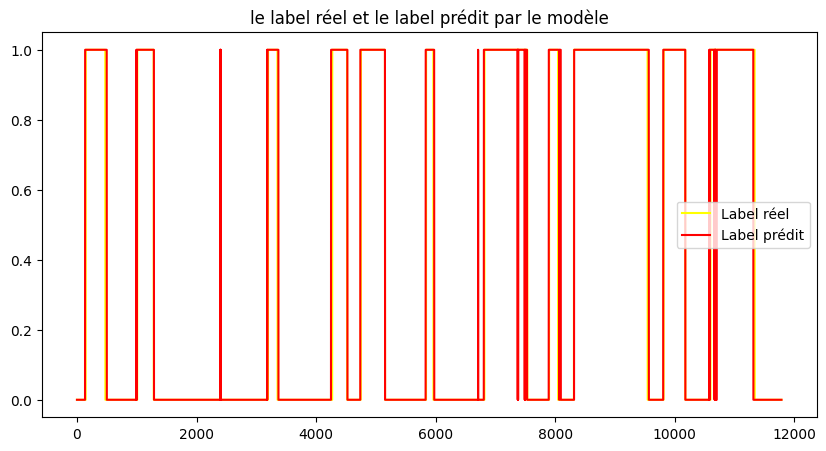

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(y_test, label='Label réel',color='yellow')
plt.plot(y_pred, label='Label prédit',color='red')
plt.title('le label réel et le label prédit par le modèle')
plt.legend()
plt.show()

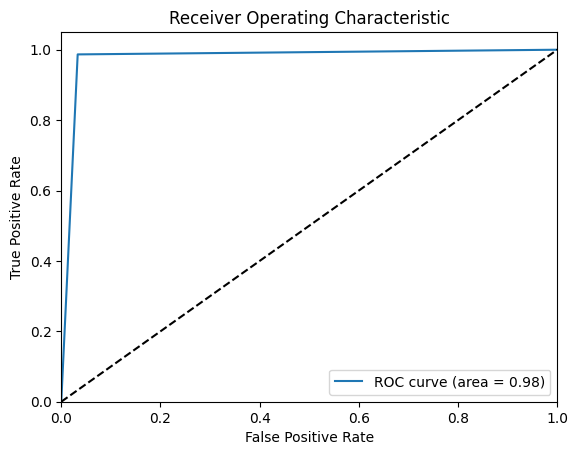

In [ ]:
# Compute the false positive rate, true positive rate, and thresholds
fpr, tpr, thresholds = roc_curve(y_test, y_prob)

# Compute the area under the ROC curve
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.plot(fpr, tpr, label='ROC curve (area = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

# Classification with SVM
## Hyperparameters finetuning
### create the objective function

In [ ]:
def cross_validation_svm(datasets, k1, gamma, c):
    """
    Effectue une validation croisée pour svm en utilisant 4 fichiers pour le train
    et 1 pour le test, avec sélection de caractéristiques.

    :param datasets: Liste de DataFrames.
    :param k1: Nombre de caractéristiques à sélectionner.
    :param gamma: Coefficient de noyau pour 'rbf'.
    :param c: Paramètre de régularisation.
    :return: Liste des résultats pour chaque combinaison.
    """
    results = []

    # Combinaisons des fichiers (4 pour le train, 1 pour le test)
    for combination in combinations(range(len(datasets)), 4):
        # Indices des fichiers de train et de test
        train_indices = [i + 1 for i in combination]
        test_index = [i + 1 for i in range(len(datasets)) if i not in combination][0]

        # Créer l'ensemble d'entraînement et de test
        train_data = pd.concat([datasets[i] for i in combination])
        test_data = datasets[[i for i in range(len(datasets)) if i not in combination][0]]

        # Séparer les features (X) et les labels (y)
        X_train, y_train = train_data.drop(columns=['label']), train_data['label']
        X_test, y_test = test_data.drop(columns=['label']), test_data['label']

        # Sélection des caractéristiques
        selector = SelectKBest(score_func=f_classif, k=int(k1))
        X_train_selected = selector.fit_transform(X_train, y_train)
        X_test_selected = selector.transform(X_test)

        # Entraîner le modèle decision tree
        clf = SVC(gamma=gamma, C=c)
        clf.fit(X_train_selected, y_train)

        # Prédire sur les données de test
        y_pred = clf.predict(X_test_selected)

        # Calculer le F1-score
        score = f1_score(y_test, y_pred, average='weighted')
        results.append((train_indices, test_index, score))

    return results

# Paramètre pour le nombre de caractéristiques
k1 = 21
gamma = 9.659
c = 1.447 

# Lancer la validation croisée
results = cross_validation_svm(datasets, k1, gamma, c)

# Afficher les résultats
for i, (train_files, test_file, score) in enumerate(results, 1):
    print(f"### Combinaison {i} ###")
    print(f"Fichiers pour le train: {train_files}")
    print(f"Fichier pour le test: {test_file}")
    print(f"F1-score pour cette combinaison: {score:.4f}\n")

# Moyenne des F1-scores
mean_score = np.mean([score for _, _, score in results])
print(f"Moyenne des F1-scores : {mean_score:.4f}")

# Ecart-type des F1-scores
std_score = np.std([score for _, _, score in results])
print(f"Ecart-type des F1-scores : {std_score:.4f}")

### Combinaison 1 ###
Fichiers pour le train: [1, 2, 3, 4]
Fichier pour le test: 5
F1-score pour cette combinaison: 0.8645

### Combinaison 2 ###
Fichiers pour le train: [1, 2, 3, 5]
Fichier pour le test: 4
F1-score pour cette combinaison: 0.9234

### Combinaison 3 ###
Fichiers pour le train: [1, 2, 4, 5]
Fichier pour le test: 3
F1-score pour cette combinaison: 0.8708

### Combinaison 4 ###
Fichiers pour le train: [1, 3, 4, 5]
Fichier pour le test: 2
F1-score pour cette combinaison: 0.8356

### Combinaison 5 ###
Fichiers pour le train: [2, 3, 4, 5]
Fichier pour le test: 1
F1-score pour cette combinaison: 0.9408

Moyenne des F1-scores : 0.8870
Ecart-type des F1-scores : 0.0391


In [ ]:
def my_svm(k1, c, gamma):
    # Perform feature selection
    selector = SelectKBest(score_func=f_classif, k=int(k1))
    X_selected = selector.fit_transform(X, y) # select the top k1 features from the dataset
    X_selected = pd.DataFrame(X_selected, columns=X.columns[selector.get_support()])

    # split data into train and test sets
    X_train = pd.concat([data2,data3, data4, data5]).drop('label', axis=1)
    X_test = data1.drop('label', axis=1)
    y_train = pd.concat([data2,data3, data4, data5])['label']
    y_test = data1['label']

    # Select the features for the test data
    X_test = X_test[X_selected.columns].to_numpy()
    X_train = X_train[X_selected.columns].to_numpy()

    # Create a SVM classifier
    clf = SVC(C=c, gamma=gamma) # C is the regularization parameter, gamma is the kernel coefficient for 'rbf' kernel

    # Train the classifier
    clf.fit(X_train, y_train)

    # Make predictions on the test data
    y_pred = clf.predict(X_test)

    # Evaluate the model
    return f1_score(y_test, y_pred, average='weighted')

In [ ]:
pbounds = {
    'k1': (5, 21), # number of features to select
    'c': (1, 10), # regularization parameter
    'gamma': (1, 10) # kernel coefficient for 'rbf' kernel
    }

optimizer = BayesianOptimization(
    f=my_svm,
    pbounds=pbounds,
    verbose=2,
    random_state=1,
)

start = time.time()
optimizer.maximize(init_points=10, n_iter=10) 
end = time.time()
print('Bayes optimization takes {:.2f} seconds to tune'.format(end - start))
print(optimizer.max)

|   iter    |  target   |     c     |   gamma   |    k1     |
-------------------------------------------------------------
| 1         | 0.5949    | 4.753     | 7.483     | 5.002     |
| 2         | 0.6603    | 3.721     | 2.321     | 6.477     |
| 3         | 0.7461    | 2.676     | 4.11      | 11.35     |
| 4         | 0.9063    | 5.849     | 4.773     | 15.96     |
| 5         | 0.6027    | 2.84      | 8.903     | 5.438     |
| 6         | 0.9052    | 7.034     | 4.756     | 13.94     |
| 7         | 0.8973    | 2.263     | 2.783     | 17.81     |
| 8         | 0.9172    | 9.714     | 3.821     | 16.08     |
| 9         | 0.6974    | 8.888     | 9.051     | 6.361     |
| 10        | 0.9033    | 1.351     | 2.528     | 19.05     |
| 11        | 0.9362    | 9.65      | 9.967     | 20.69     |
| 12        | 0.9406    | 1.447     | 9.659     | 20.91     |
| 13        | 0.9257    | 9.905     | 9.59      | 15.04     |
| 14        | 0.8954    | 5.913     | 1.424     | 20.96     |
| 15    

In [ ]:
# Perform feature selection
selector = SelectKBest(score_func=f_classif, k=21)
X_selected = selector.fit_transform(X, y)
X_selected = pd.DataFrame(X_selected, columns=X.columns[selector.get_support()])

# split data into train and test sets
X_train = pd.concat([data2,data3, data4, data5]).drop('label', axis=1)
X_test = data1.drop('label', axis=1)
y_train = pd.concat([data2,data3, data4, data5])['label']
y_test = data1['label']

# Select the features for the test data
X_test = X_test[X_selected.columns].to_numpy()
X_train = X_train[X_selected.columns].to_numpy()

start_time = time.time()

# Create a SVM classifier
clf = SVC(C=1, gamma=10)

# Train the classifier
clf.fit(X_train, y_train)


# Make predictions on the test data
y_pred = clf.predict(X_test)

execution_time = time.time() - start_time

# Evaluate the performance of the classifier
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

# ROC curve multi-class classification
y_prob = clf.decision_function(X_test) # decision_function will return the confidence scores for each class
macro_roc_auc_ovo = roc_auc_score(y_test.to_numpy(), y_prob, multi_class="ovo", average="macro")

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Get the TP, TN, FP, FN values
FP = cm.sum(axis=0) - np.diag(cm)  
FN = cm.sum(axis=1) - np.diag(cm)
TP = np.diag(cm)
TN = cm.sum() - (FP + FN + TP)
# Get the bias and variance of the classifier
loss, bias, var = bias_variance_decomp(clf,X_train, y_train.to_numpy(), X_test, y_test.to_numpy(), loss='0-1_loss',random_seed=23)

# Print the evaluation metrics
# print("Loss:", loss)
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)
print("TP:", TP.sum())
print("TN:", TN.sum())
print("FP:", FP.sum())
print("FN:", FN.sum())
print("AUC:", macro_roc_auc_ovo)
# print("Bias:", bias)
# print("Variance:", var)
print(f"Execution Time: {execution_time} seconds")

Accuracy: 0.9405867062755291
Precision: 0.9485170205789965
Recall: 0.9405867062755291
F1 Score: 0.9422501622125652
TP: 12665
TN: 12665
FP: 800
FN: 800
AUC: 0.985083952480986
Execution Time: 332.16295051574707 seconds


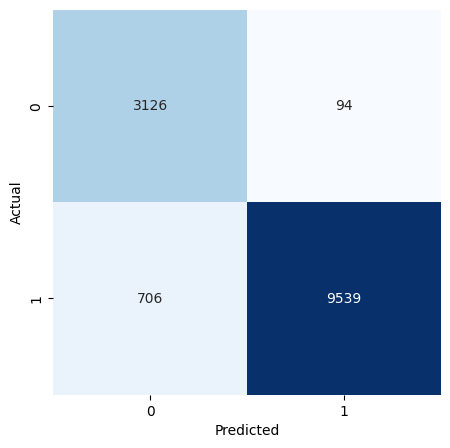

In [ ]:
plt.figure(figsize=(5, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

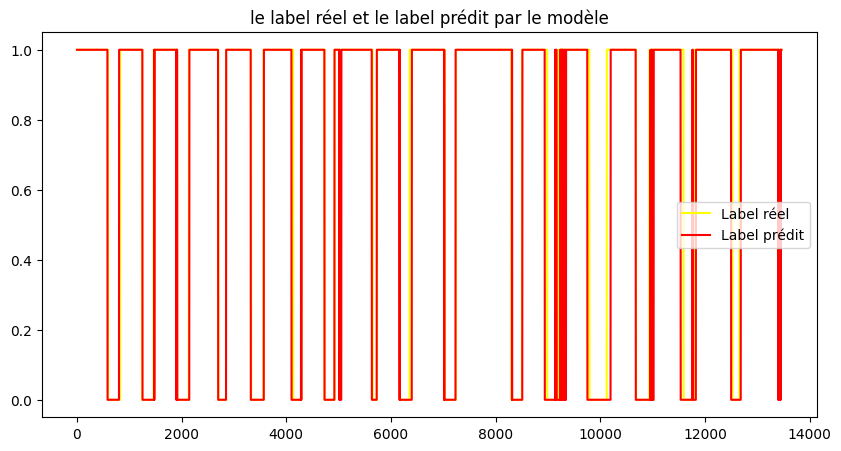

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(y_test, label='Label réel',color='yellow')
plt.plot(y_pred, label='Label prédit',color='red')
plt.title('le label réel et le label prédit par le modèle')
plt.legend()
plt.show()

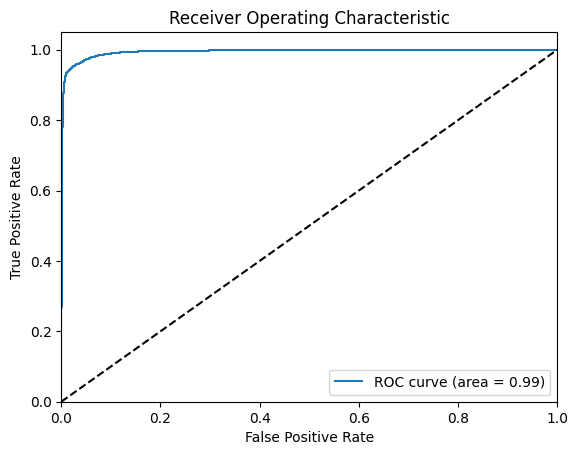

In [ ]:
# Compute the false positive rate, true positive rate, and thresholds
fpr, tpr, thresholds = roc_curve(y_test, y_prob)

# Compute the area under the ROC curve
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.plot(fpr, tpr, label='ROC curve (area = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()